<a href="https://colab.research.google.com/github/KeqingW44448/api/blob/main/RSM8421/Assignments/Assignment%20Two/Problem_2_(16_marks%2C_2_marks_for_each_sub_question).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning Exercises
This notebook provides a set of exercises on transfer learning. Run the cells as instructed and answer the **questions** that follow each exercise.

In [ ]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D
from scipy.ndimage import zoom

## Load Data
We will use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), which consists of natural images categorized into 10 classes (e.g., cars, dogs, birds).

In [ ]:
batch_size = 100
num_classes = 10
epochs = 20

# input image dimensions
img_rows, img_cols, img_channels = 32, 32, 3

In [ ]:

 (x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Convert class vectors to one-hot encodings
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Define input shape
input_shape = (img_rows, img_cols, img_channels)

# For this demonstration, select 1k random samples for training and test
index = np.arange(x_train.shape[0])
np.random.seed(0)
np.random.shuffle(index)
index = index[:1000]
x_train, y_train = x_train[index], y_train[index]

index = np.arange(x_test.shape[0])
np.random.seed(0)
np.random.shuffle(index)
index = index[:1000]
x_test, y_test = x_test[index], y_test[index]

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
x_train shape: (1000, 32, 32, 3)
y_train shape: (1000, 10)
1000 train samples
1000 test samples


## Exercise 1: CNN From Scratch
Build a convolutional neural network (CNN) from scratch using a small subset of the CIFAR-10 training data (1,000 samples).

In [ ]:
x_scaled_train = x_train / 255.
x_scaled_test = x_test / 255.

In [ ]:
model1 = Sequential()
model1.add(Input(shape=input_shape))
model1.add(Conv2D(16, kernel_size=(3, 3),
                  strides=1, padding='valid',
                  activation='relu'))
model1.add(Conv2D(16, kernel_size=(3, 3),
                  strides=2, padding='valid',
                  activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dense(num_classes, activation='softmax'))

model1.compile(loss='categorical_crossentropy',
               optimizer=keras.optimizers.Adam(learning_rate=0.01),
               metrics=['accuracy'])
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,658 (209.60 KB)

 Trainable params: 53,658 (209.60 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model1.fit(x_scaled_train, y_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=0,
           callbacks=[])

In [ ]:
train_score = model1.evaluate(x_scaled_train , y_train, verbose=0)
test_score = model1.evaluate(x_scaled_test, y_test, verbose=0)

print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Train loss: 0.49095430970191956
Train accuracy: 0.8450000286102295
Test loss: 2.8138749599456787
Test accuracy: 0.36399999260902405


## Questions

1. Why is there a substantial gap between the training and testing accuracy?
2. Why is the performance so poor?

## Exercise 2: Using Pre-Processed Features
Load a pre-trained MobileNet model (an efficient, lightweight network with approximately 4M parameters and strong performance on ImageNet) and extract features from the training and test sets.
Note: Use the parameter `include_top=False` to exclude the default ImageNet classifier.

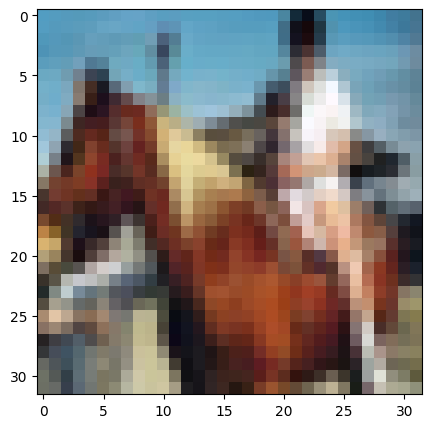

In [ ]:
# Plot a sample image (so we can make sure our transformations are correct)
plt.figure(figsize=(5, 5))
plt.imshow(x_train[0].astype(int))
plt.show()

In [ ]:
# Some pre-processing of the image for MobileNet (scaling and shifting to be between [-1, 1])
x_preprocess_train = preprocess_input(x_train.copy())
x_preprocess_test = preprocess_input(x_test.copy())
x_preprocess_train.shape, x_preprocess_test.shape


print(x_preprocess_train.min(), x_preprocess_train.max())

-1.0 1.0


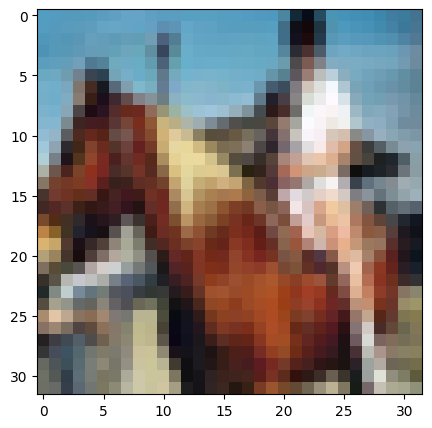

In [ ]:
# Plot a sample image (need to shift/scale to display colors properly)
plt.figure(figsize=(5, 5))
plt.imshow((x_preprocess_train[0] + 1.0) * 127.5 / 255)
plt.show()

In [ ]:
# Upsample and resize image because it expects an image up to 224x224x3 (this might take a few minutes)
print('Processing training data')
resized_images = []
for i in range(x_preprocess_train.shape[0]):
    resized_images.append(zoom(x_preprocess_train[i], (7.0, 7.0, 1.0)))
    if (i+1) % 200 == 0:
        print('* Processed %d images' % (i+1))
x_preprocess_train = np.stack(resized_images)

print('Processing testing data')
resized_images = []
for i in range(x_preprocess_test.shape[0]):
    resized_images.append(zoom(x_preprocess_test[i], (7.0, 7.0, 1.0)))
    if (i+1) % 200 == 0:
        print('* Processed %d images' % (i+1))
x_preprocess_test = np.stack(resized_images)

x_preprocess_train.shape, x_preprocess_test.shape

Processing training data
* Processed 200 images
* Processed 400 images
* Processed 600 images
* Processed 800 images
* Processed 1000 images
Processing testing data
* Processed 200 images
* Processed 400 images
* Processed 600 images
* Processed 800 images
* Processed 1000 images


((1000, 224, 224, 3), (1000, 224, 224, 3))

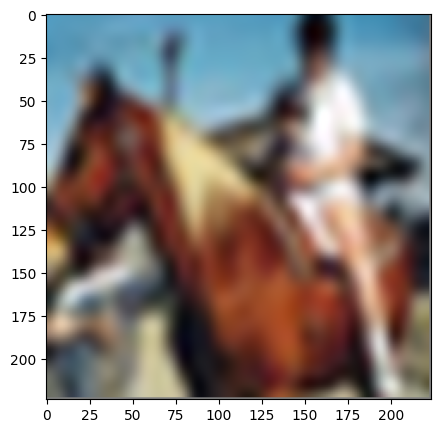

In [ ]:
# Plot a sample image (should be resized)
plt.figure(figsize=(5, 5))
plt.imshow((x_preprocess_train[0] + 1.0) * 127.5 / 255)
plt.show()

In [ ]:
mobilenet = MobileNet(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
mobilenet

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


<Functional name=mobilenet_1.00_224, built=True>

In [ ]:
# Extract features using mobilenet (this may take a few minutes)
x_preprocess_train = mobilenet.predict(x_preprocess_train)
x_preprocess_test = mobilenet.predict(x_preprocess_test)
x_preprocess_train.shape, x_preprocess_test.shape

32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 294ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


((1000, 7, 7, 1024), (1000, 7, 7, 1024))

### Model

Next, we will build a simple feed-forward network using the extracted features.

Before its top layer, MobileNet produces a tensor of shape (5, 5, 1024). We aggregate this output using a **GlobalAveragePooling** layer, which compresses it into a (1, 1, 1024) tensor—equivalent to a 1024-dimensional vector. This layer operates by computing the average of each 5×5 feature map.

In [ ]:
model2 = Sequential()
model2.add(Input(shape=(5, 5, 1024)))
model2.add(GlobalAveragePooling2D())
model2.add(Dense(64, activation='relu'))
model2.add(Dense(num_classes, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
               optimizer=keras.optimizers.Adam(learning_rate=0.001),
               metrics=['accuracy'])
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,250 (258.79 KB)

 Trainable params: 66,250 (258.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.fit(x_preprocess_train, y_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=0,
           callbacks=[])

In [ ]:
train_score = model2.evaluate(x_preprocess_train, y_train, verbose=0)
test_score = model2.evaluate(x_preprocess_test, y_test, verbose=0)

print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Train loss: 0.05705704912543297
Train accuracy: 0.9990000128746033
Test loss: 0.5815247297286987
Test accuracy: 0.7879999876022339


## Questions
1. What happens if the `GlobalAveragePooling2D` layer is omitted?
    - Provide a hypothesis for why the performance changes.
2. Why must the images be preprocessed using the `preprocess_input` function?  
   - What would you expect to occur if this step were skipped?  
3. Why is it necessary to resize the images (using `zoom`)?  
   - Recall that ImageNet images are 224×224×3, while CIFAR-10 images are 32×32×3.  
   - Consider how objects such as "cars" or "horses" differ between the two datasets.

## Exercise 3: Using Frozen Layers in a Pre-trained Network
Load a pre-trained MobileNet model and keep its layers **frozen**, rather than working with pre-processed feature tensors.

In [ ]:
x_frozen_preprocess_train = preprocess_input(x_train.copy())
x_frozen_preprocess_test = preprocess_input(x_test.copy())

In [ ]:
mobilenet_base = MobileNet(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
mobilenet_base

<Functional name=mobilenet_1.00_224, built=True>

In [ ]:
model3 = Sequential()

model3.add(Input(shape=(32, 32, 3)))
model3.add(UpSampling2D(size=(7,7)))
model3.add(mobilenet_base)
model3.add(GlobalAveragePooling2D())
model3.add(Dense(64, activation='relu'))
model3.add(Dense(num_classes, activation='softmax'))


#Unfreeze last N layers
N = 5
for layer in mobilenet_base.layers[:-N]:
    layer.trainable = False
for layer in mobilenet_base.layers[-N:]:
    layer.trainable = True

# Lower learning rate for fine-tuning
model3.compile(loss='categorical_crossentropy',
               optimizer=keras.optimizers.Adam(learning_rate=0.0001),
               metrics=['accuracy'])

In [ ]:
# This may take a while (unless you're using a GPU), so we will only do 3 epochs to speed things up.
model3.fit(x_frozen_preprocess_train, y_train,
           batch_size=batch_size,
           epochs=3,
           verbose=0,
           callbacks=[])

In [ ]:
train_score = model3.evaluate(x_frozen_preprocess_train, y_train, verbose=0)
test_score = model3.evaluate(x_frozen_preprocess_test, y_test, verbose=0)

print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Train loss: 1.8562244176864624
Train accuracy: 0.4000000059604645
Test loss: 2.0288615226745605
Test accuracy: 0.36399999260902405


## Questions
1. Why does the network train much more slowly?  
2. What differences, if any, exist between the model in Exercise 2 and the model in Exercise 3?  
3. How could the code be modified to train some of the MobileNet layers?